In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from simulate_ifgs import (
    generate_mogi, generate_tilt, generate_dislocation,
    combine_sources, wrap_phase,
    add_gaussian_noise, add_random_nans, add_patch_nans,
    add_atmospheric_noise, add_non_gaussian_noise
)
from fft_unwrap_bridge import unwrap_phase_fft_bridge
from coherence import calculate_coherence_numpy

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
n = 1000
phi_mogi      = generate_mogi(n, center=(0.2, -0.1), depth=0.3, deltaV=2.0)
wrap_mogi     = wrap_phase(phi_mogi)
phi_tilt      = generate_tilt(n, slope_x=0.5, slope_y=-0.2)
wrap_tilt     = wrap_phase(phi_tilt)
phi_edge      = generate_dislocation(n, fault_angle=np.pi/6, jump=1.5)
wrap_edge     = wrap_phase(phi_edge)
second_mogi   = generate_mogi(n, center=(-0.3,0.4), depth=0.2, deltaV=-1.5)
phi_multi     = combine_sources(n, [phi_mogi, second_mogi, phi_edge], [1,1,0.8])
wrap_multi    = wrap_phase(phi_multi)
wrap_mogi_noise = add_gaussian_noise(wrap_mogi, sigma=0.2)
wrap_mogi_noise = add_random_nans(wrap_mogi_noise, percent=0.1)
wrap_mogi_noise = add_patch_nans(wrap_mogi_noise, num_patches=2, max_radius=150)
phi_atmo      = add_atmospheric_noise(phi_mogi, scale=0.1, smooth_sigma=100)
wrap_atmo     = wrap_phase(phi_atmo)
phi_ngn       = add_non_gaussian_noise(phi_mogi, thermal_sigma=0.05,
                                       speckle_coh=0.7, smooth_sigma=50)
wrap_ngn = add_non_gaussian_noise(wrap_mogi, thermal_sigma=0.05,
                                  speckle_coh=0.7, smooth_sigma=50)

wrapped_list  = [wrap_mogi, wrap_tilt, wrap_edge, wrap_multi, wrap_mogi_noise, wrap_atmo, wrap_ngn]
deform_list   = [phi_mogi, phi_tilt, phi_edge, phi_multi, phi_mogi, phi_atmo, phi_mogi]
titles        = ["Mogi", "Tilt", "Edge Dislocation", "Multiple Sources",
                 "Mogi+Noise/NaNs", "Mogi+Atmosphere", "NonGaussNoise"]

### Spheroidal/Mogi Source  
Represents an inflating or deflating point source (e.g., magma chamber). This generates a roughly radial, bell-shaped uplift, producing concentric phase fringes. Fringe density increases toward the center, creating high phase gradients and many 2π ambiguities for large volume changes. In noisy or decorrelated regions, coherence drops below one, and unwrappers must bridge gaps between reliable patches.

### Planar/Tilt Signal  
A simple linear ramp across the image, simulating orbital ramps or broad tilting. Ideal unwrapping is trivial, but real-world noise, decorrelation, and non-linear residuals can induce errors in your ramp-removal step. Coherence remains high but may dip at scene edges or over water bodies when valid pixels are sparse.

### Edge Dislocation  
Models fault slip (e.g., earthquake) as a sharp phase step along a line. Intense phase gradients concentrate on the fault, challenging both path-following and least-squares methods. Coherence typically remains high away from shadows or layover but may suffer near abrupt geometry changes.

### Multiple Sources  
Combines two or more signals (e.g., two Mogi plus one dislocation). Vary separation and relative amplitudes to test handling of multiple distinct fringe zones and the bridging between them. Coherence patterns mirror each individual source’s noise and masking footprint.

### Noise & Decorrelation Layers  
After wrapping the true phase, layer on realistic complications:

- **Non-Gaussian Speckle & Thermal Noise**: Simulate independent SAR images with speckle plus additive Gaussian phase noise before interferogram formation. This yields spatially correlated, non-Gaussian phase errors and realistic coherence variations.  
- **Gaussian Noise**: Simpler additive complex Gaussian noise on the interferogram, lowering coherence uniformly.  
- **Missing Data / Low Coherence**: Introduce NaNs randomly or as contiguous patches (water, vegetation changes, lava) to test your NaN‐replacement and bridging.  
- **Edge NaNs**: Mask entire edges to test boundary handling—coherence will be `NaN` where valid data are insufficient.  
- **Atmospheric-like Variations**: Add smooth, correlated phase distortion via filtered white noise, producing coherence gradients at larger scales.

### Combined Scenarios  
- Steep deformation gradient + high speckle noise + large NaN patches  
- Multiple sources + decorrelation cutting through fringes  
- Large Mogi uplift bisected by a decorrelation patch (lava flow)  
- Realistic “Kīlauea-style” case: inflation + decorrelation + atmospheric turbulence  

Each scenario yields distinct coherence maps (from near 1 in well-correlated regions to `NaN` or ≪ 1 in noisy/masked areas)

In [34]:
def compute_metrics(phi_true, phi_algo, tol=np.pi):
    """
    Compute MAE, RMSE, and percent-correct within ±tol.
    Both inputs are 2D numpy arrays of same shape.
    """
    # mask out any nan in true or algo
    mask = np.isfinite(phi_true) & np.isfinite(phi_algo)
    err = phi_algo[mask] - phi_true[mask]
    # bring error into [-pi, pi]
    err = (err + np.pi) % (2*np.pi) - np.pi
    
    mae  = np.mean(np.abs(err))
    rmse = np.sqrt(np.mean(err**2))
    pct  = np.mean(np.abs(err) <= tol) * 100.0
    return mae, rmse, pct, err.reshape(phi_true[mask].shape)

In [35]:
# The overall runtime of the unwrapping algorithm scales as O(n^2 log n) due to:
#   1. Poisson solve via 2D FFT: O(n^2 log n)
#   2. Fixed-window uniform filters: O(n^2)
# Combined: O(n^2 log n)

In [36]:
results, error_maps, unwrapped_list, coh_maps = [], [], [], []
for title, phi_true, wrap in zip(titles, deform_list, wrapped_list):
    # unwrap
    phi_algo = unwrap_phase_fft_bridge(wrap, window=5,
                threshold_factor=1.5, min_region_size=100,
                bridge_window=16, verbose=False)
    unwrapped_list.append(phi_algo)
    # coherence
    # 1) Build two speckled SAR images ground truth +- phase noise
    img1 = np.sqrt(-2*np.log(np.random.rand(*phi_true.shape))) * \
        np.exp(1j*(phi_true + np.random.randn(*phi_true.shape)*0.1))
    img2 = np.sqrt(-2*np.log(np.random.rand(*phi_true.shape))) * \
        np.exp(1j*(phi_true + np.random.randn(*phi_true.shape)*0.1))
    # 2) Compute coherence on those
    img1 = img1.astype(np.complex64)
    img2 = img2.astype(np.complex64)
    coh = calculate_coherence_numpy(img1, img2,
                                    window=7, min_valid_ratio=0.5)
    coh_maps.append(coh)
    # metrics
    mae, rmse, pct, _ = compute_metrics(phi_true, phi_algo)
    results.append({"case":title, "MAE":mae, "RMSE":rmse, "PctCorrect(π)":pct})
    # error map
    full_err = np.full_like(phi_true, np.nan)
    mask = np.isfinite(phi_true)&np.isfinite(phi_algo)
    full_err[mask] = ((phi_algo-phi_true+np.pi)%(2*np.pi)-np.pi)[mask]
    error_maps.append(full_err)

In [37]:
df = pd.DataFrame(results).set_index("case")
df

,MAE,RMSE,PctCorrect(π)
case,,,
Mogi,2.291256,2.342679,100.0
Tilt,0.270090,0.322637,100.0
Edge Dislocation,1.529660,1.793905,100.0
Multiple Sources,1.251431,1.548658,100.0
Mogi+Noise/NaNs,1.661398,1.863592,100.0
Mogi+Atmosphere,2.291230,2.342641,100.0
NonGaussNoise,0.926504,1.172127,100.0


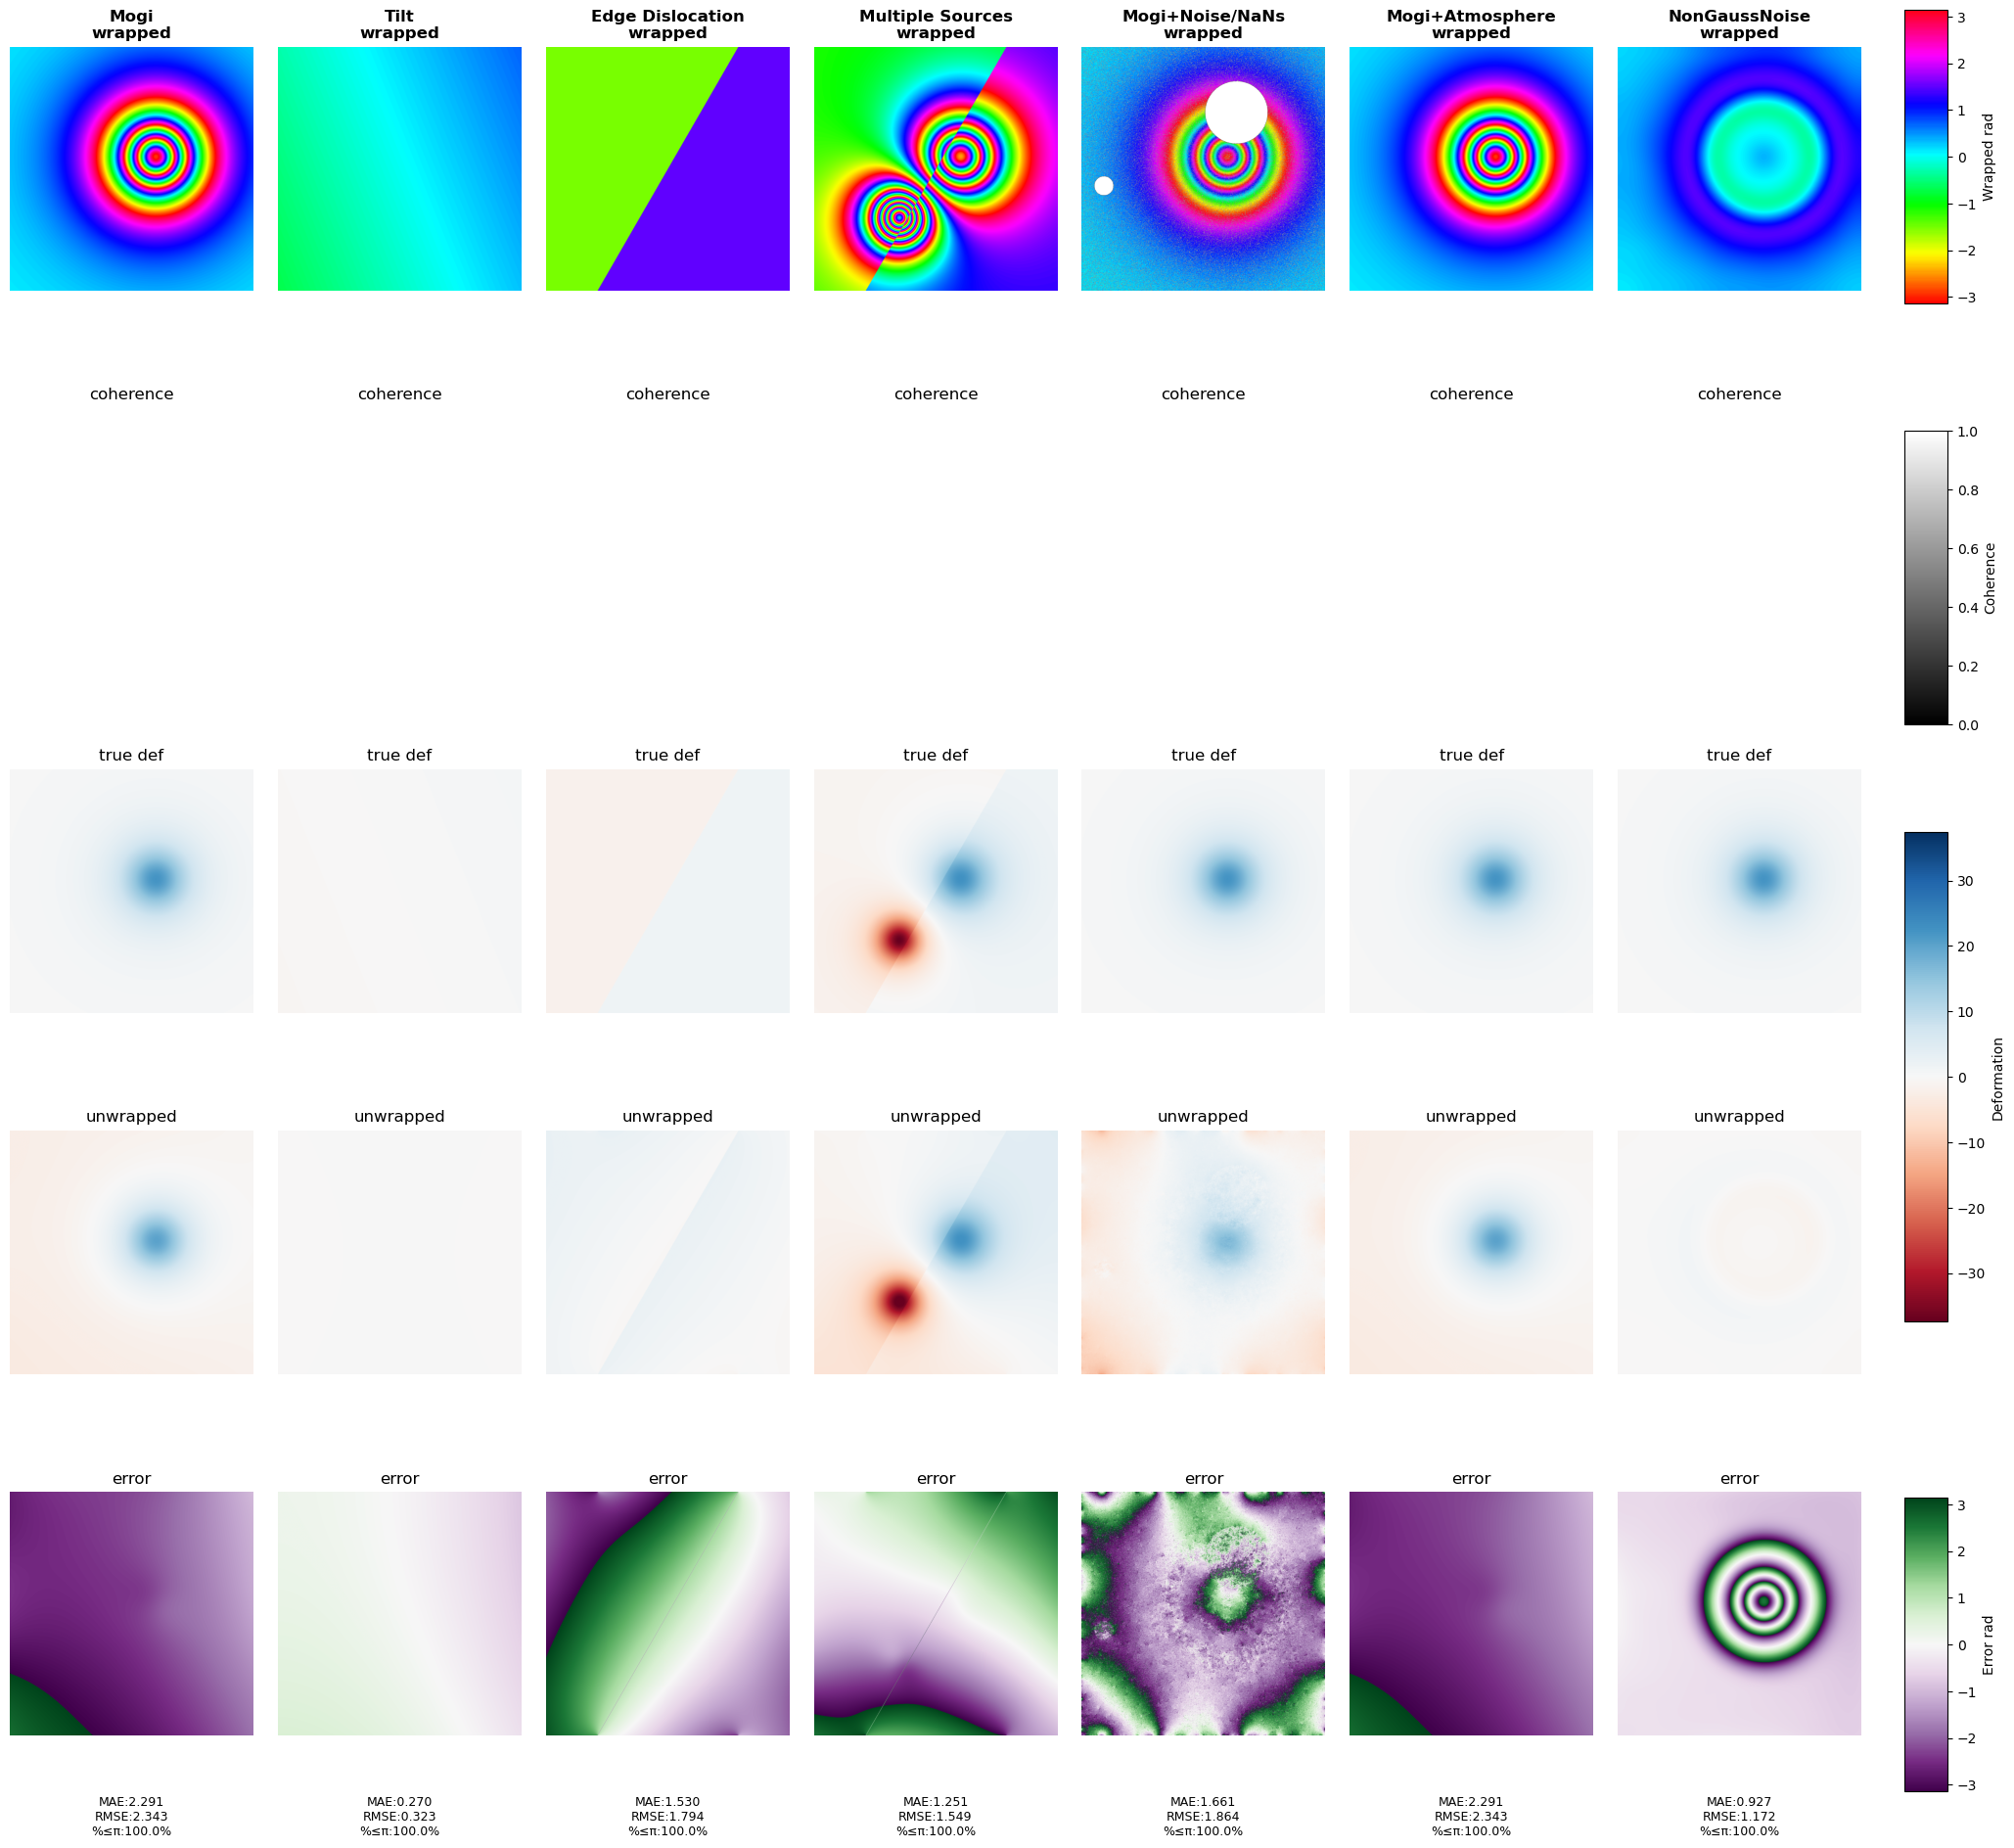

In [39]:
ncase = len(titles)
ifg_vmin, ifg_vmax = -np.pi, np.pi
max_dev = max(np.max(np.abs(p)) for p in deform_list)
dev_vmin, dev_vmax = -max_dev, max_dev
err_vmin, err_vmax = -np.pi, np.pi
coh_vmin, coh_vmax = 0, 1

fig, axes = plt.subplots(5, ncase, figsize=(3*ncase+1, 20), constrained_layout=False)

for i, title in enumerate(titles):
    # IFG
    axes[0,i].imshow(wrapped_list[i], cmap='hsv', vmin=ifg_vmin, vmax=ifg_vmax)
    axes[0,i].set_title(f"{title}\nwrapped", fontweight="bold"); axes[0,i].axis('off')
    # coherence
    axes[1,i].imshow(coh_maps[i], cmap='gray', vmin=coh_vmin, vmax=coh_vmax)
    axes[1,i].set_title("coherence"); axes[1,i].axis('off')
    # true
    axes[2,i].imshow(deform_list[i], cmap='RdBu', vmin=dev_vmin, vmax=dev_vmax)
    axes[2,i].set_title("true def"); axes[2,i].axis('off')
    # unwrapped
    axes[3,i].imshow(unwrapped_list[i], cmap='RdBu', vmin=dev_vmin, vmax=dev_vmax)
    axes[3,i].set_title("unwrapped"); axes[3,i].axis('off')
    # error
    axes[4,i].imshow(error_maps[i], cmap='PRGn', vmin=err_vmin, vmax=err_vmax)
    axes[4,i].set_title("error"); axes[4,i].axis('off')
    # annotate metrics
    m = results[i]
    txt = f"MAE:{m['MAE']:.3f}\nRMSE:{m['RMSE']:.3f}\n%≤π:{m['PctCorrect(π)']:.1f}%"
    axes[4,i].text(0.5,-0.25, txt, transform=axes[4,i].transAxes,
                   ha='center', va='top', fontsize=9)

# colorbars
plt.subplots_adjust(left=0.02, right=0.88, top=0.96, bottom=0.08, hspace=0.3, wspace=0.1)
cb_ifg = fig.add_axes([0.90, 0.82, 0.02, 0.15])
fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(ifg_vmin,ifg_vmax), cmap='hsv'),
             cax=cb_ifg, label='Wrapped rad')
cb_coh = fig.add_axes([0.90, 0.605, 0.02, 0.15])
fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(coh_vmin,coh_vmax), cmap='gray'),
             cax=cb_coh, label='Coherence')
cb_dev = fig.add_axes([0.90, 0.3, 0.02, 0.25])
fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(dev_vmin,dev_vmax), cmap='RdBu'),
             cax=cb_dev, label='Deformation')
cb_err = fig.add_axes([0.90, 0.06, 0.02, 0.15])
fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(err_vmin,err_vmax), cmap='PRGn'),
             cax=cb_err, label='Error rad')

plt.show()